Sample code for computing Performance Profiles for different methods on the Arcade Learning Environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

In [2]:
def poor_man_welch_test(target_mean,target_std,target_n,comp_mean,comp_std,comp_n):
    # Computes a Welch test to see if the comparitor sample is larger than the target sample.
    # This works from sufficient statistics alone, and that's because this is all that 
    # people report in their papers. I'm no more happy about this than you are.
    
    nu = ((target_std**2/target_n + comp_std**2/comp_n)**2/
         (target_std**4/target_n/(target_n-1)+ comp_std**4/comp_n/(comp_n-1)))
    t_stat = ((target_mean-comp_mean)
              /np.sqrt(target_std**2/target_n+comp_std**2/comp_n))
            
    return 0.5*betainc(nu/2,1/2,nu/(t_stat**2+nu))

def optimality_deviation(data_means,data_std,data_n):
    # compute the deviation from optimality as given by the log-likehood of a Welch t-test 
    num_prob, num_method = data_means.shape
    likelihood = np.zeros((num_prob,num_method))    
    for prob in range(num_prob):
        best_idx = np.argmax(data_means[prob,:])

        # compute the Welsh t-test to determine the p-value associated 
        # with a method having mean higher than the observed highest reward
        for method in range(num_method):
            likelihood[prob,method] = -np.log10(poor_man_welch_test(
                                        data_means[prob,best_idx],data_std[prob,best_idx],data_n[prob,best_idx],
                                        data_means[prob,method],data_std[prob,method],data_n[prob,method]))

        # denote the likelihood of the best observation as being 1. This is merely counting 
        # the number of times a method achieves the highest mean.
        likelihood[prob,best_idx] = 0
    return likelihood

def welch_t_perf_prof(data_means,data_std,data_n,data_names,tau_min=0.3,tau_max=3.0,npts=100):
    num_prob, num_method = data_means.shape
    rho = np.zeros((npts,num_method))
    
    # This is the d[p,m] function discussed in the blog.
    # For this post, I'm using the log-likelihood of the Welch t-test. 
    # But this is where you'd write whatever method you think would work better.
    dist_like_fun = optimality_deviation(data_means,data_std,data_n)
             
    # Compute the cumulative rates of the distance being less than a fixed threshold
    tau = np.linspace(tau_min,tau_max,npts)
    for method in range(num_method):
        for k in range(npts):
            rho[k,method] = np.sum(dist_like_fun[:,method]<tau[k])/num_prob
    
    # make plot
    colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac","000000"]
    label_fontsize = 18
    tick_fontsize = 14
    linewidth = 3
    
    for method in range(num_method):
        plt.plot(tau,rho[:,method],color=colors[method],linewidth=linewidth,label=data_names[method])
        
    plt.xlabel(r'$-\log_{10}(\tau)$',fontsize=label_fontsize)
    plt.ylabel(r'fraction with $p_{val} \geq \tau$',fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    plt.grid(True)
    plt.show()

The data comes from the Tables 8 and 9 from paper “Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents.” https://arxiv.org/abs/1709.06009

The DQN data is in [this csv.](http://www.argmin.net/code/dqn.csv)
The Blob-PROST data is in [this csv.](http://www.argmin.net/code/blob.csv)

In [3]:
blob_data = np.genfromtxt('blob.csv', delimiter=',')
dqn_data = np.genfromtxt('dqn.csv', delimiter=',')

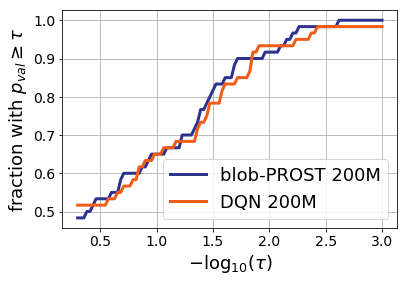

In [4]:
data_means = np.vstack((blob_data[:,6],dqn_data[:,6])).T
data_std = np.vstack((blob_data[:,7],dqn_data[:,7])).T + 1.0e-6
data_n = np.tile(np.array([24,5]).T,[60,1])
data_names = ['blob-PROST 200M','DQN 200M']
welch_t_perf_prof(data_means,data_std,data_n,data_names)

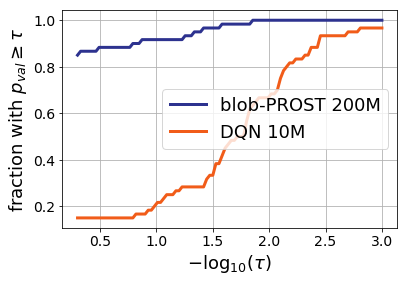

In [5]:
data_means = np.vstack((blob_data[:,6],dqn_data[:,0])).T
data_std = np.vstack((blob_data[:,7],dqn_data[:,1])).T + 1.0e-6
data_n = np.tile(np.array([24,5]).T,[60,1])
data_names = ['blob-PROST 200M','DQN 10M']
welch_t_perf_prof(data_means,data_std,data_n,data_names)

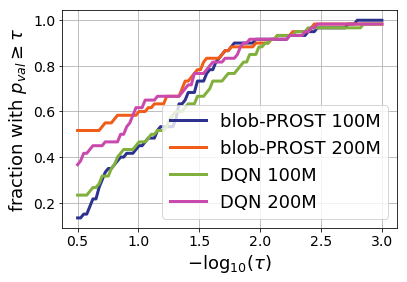

In [6]:
data_means = np.vstack((blob_data[:,4],blob_data[:,6],dqn_data[:,4],dqn_data[:,6])).T
data_std = np.vstack((blob_data[:,5],blob_data[:,7],dqn_data[:,5],dqn_data[:,7])).T + 1.0e-6
data_n = np.tile(np.array([24,24,5,5]).T,[60,1])
data_names = ['blob-PROST 100M','blob-PROST 200M','DQN 100M','DQN 200M']
welch_t_perf_prof(data_means,data_std,data_n,data_names,tau_min=0.5,tau_max=3)

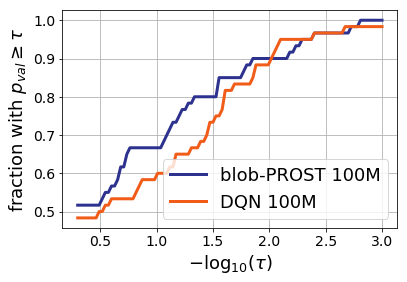

In [7]:
data_means = np.vstack((blob_data[:,4],dqn_data[:,4])).T
data_std = np.vstack((blob_data[:,5],dqn_data[:,5])).T + 1.0e-6
data_n = np.tile(np.array([24,5]).T,[60,1])
data_names = ['blob-PROST 100M','DQN 100M']
welch_t_perf_prof(data_means,data_std,data_n,data_names)